<a href="https://colab.research.google.com/github/ashwinjoseph95/2024/blob/main/Visual_text_embeddings_using_florence2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Florence-2-large sample usage

In [6]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
%matplotlib inline

In [7]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [8]:
!pip install flash_attn einops timm

## define the prediction function

In [9]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [10]:
#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('/content/Screenshot from 2025-01-05 21-04-39.jpg')

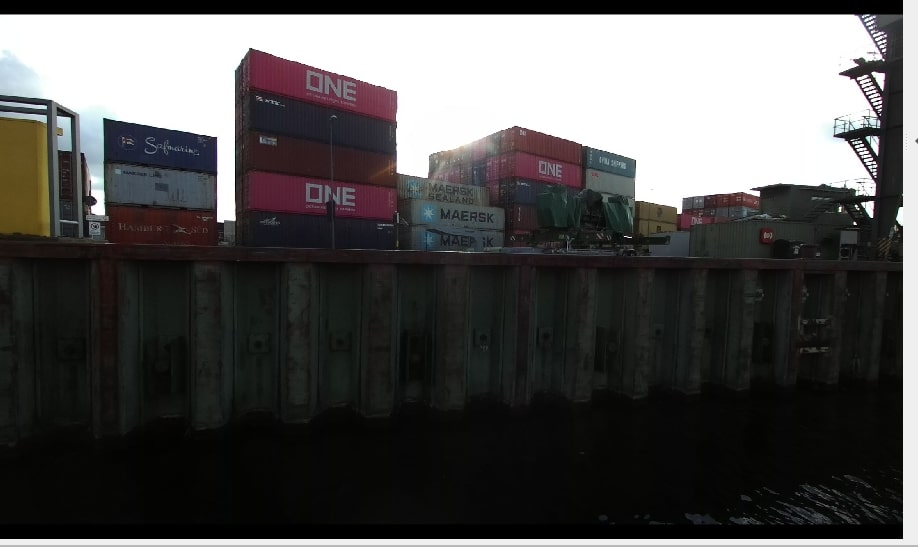

In [11]:
image

## Run pre-defined tasks without additional inputs

### Caption

In [12]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A bunch of shipping containers sitting on top of a dock.'}

In [13]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a large container ship docked at a dock with a number of containers stacked on top of it. On the right side of the image, there are a few metal objects, and in the background, the sky can be seen.'}

In [14]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a large number of shipping containers stacked on top of each other. The containers are of different colors and sizes, with some being red, blue, green, and yellow. They are stacked on a concrete wall, and there is a crane on the right side of the image. The sky is overcast and the ground is wet, suggesting that it has recently rained. The image appears to be taken from a low angle, looking up at the containers.'}

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [15]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[246.48300170898438, 48.95650100708008, 397.9530029296875, 121.1604995727539], [244.64698791503906, 170.3905029296875, 397.9530029296875, 220.71449279785156], [103.2750015258789, 118.42549896240234, 218.02499389648438, 173.12550354003906], [105.11100006103516, 162.7324981689453, 216.18899536132812, 209.7744903564453]], 'labels': ['billboard', 'billboard', 'billboard', 'billboard']}}


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

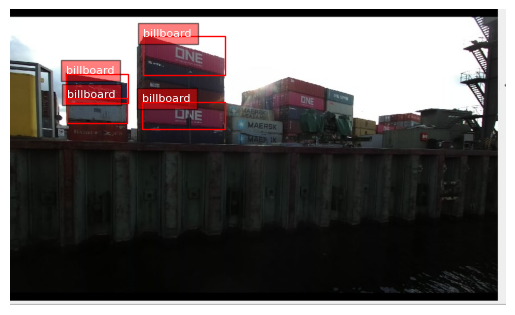

In [17]:
plot_bbox(image, results['<OD>'])

### Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [18]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[0.45899999141693115, 47.86249923706055, 902.8529663085938, 259.5514831542969], [233.63099670410156, 48.40950012207031, 401.625, 249.1584930419922], [426.4109802246094, 125.5364990234375, 639.386962890625, 247.5175018310547], [246.48300170898438, 48.95650100708008, 397.9530029296875, 120.61349487304688], [245.56500244140625, 170.3905029296875, 397.9530029296875, 220.71449279785156], [103.2750015258789, 118.42549896240234, 218.02499389648438, 172.5784912109375], [105.11100006103516, 162.7324981689453, 216.18899536132812, 209.7744903564453]], 'labels': ['containers at port with crane and shipping containers', 'One World Trade Center shipping containers', 'containers', 'billboard', 'billboard', 'billboard', 'billboard']}}


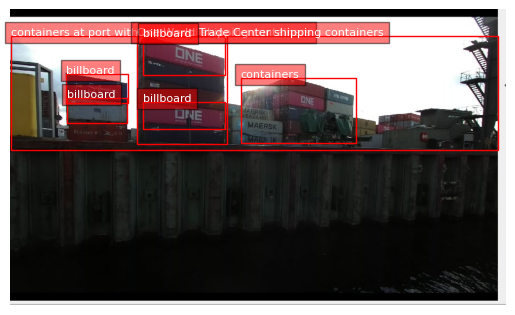

In [19]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format:
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [20]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[0.45899999141693115, 47.86249923706055, 906.5249633789062, 450.4544982910156], [0.45899999141693115, 47.86249923706055, 901.0169677734375, 258.4574890136719], [232.71299743652344, 48.40950012207031, 401.625, 249.7054901123047], [426.4109802246094, 125.5364990234375, 639.386962890625, 248.6114959716797], [101.43899536132812, 117.87849426269531, 220.77899169921875, 245.87649536132812], [0.45899999141693115, 94.35749816894531, 94.09500122070312, 239.8594970703125], [246.48300170898438, 48.95650100708008, 397.9530029296875, 120.61349487304688], [246.48300170898438, 91.07550048828125, 397.0350036621094, 153.98049926757812], [243.72898864746094, 170.3905029296875, 397.9530029296875, 220.71449279785156]], 'labels': ['', '', '', '', '', '', '', '', '']}}


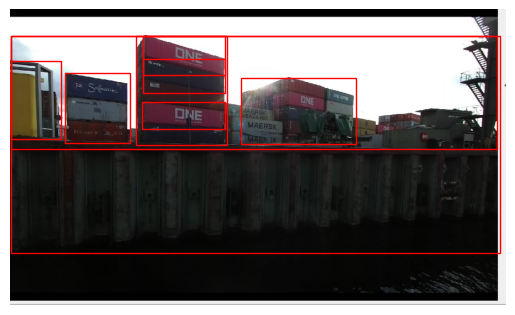

In [21]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [22]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="detect all the  objects, not sky or water surface")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[231.7949981689453, 46.221500396728516, 401.625, 250.25250244140625], [99.60299682617188, 115.69049835205078, 220.77899169921875, 247.5175018310547], [3.2129998207092285, 15.042499542236328, 901.9349975585938, 240.9534912109375], [2.2950000762939453, 13.94849967956543, 901.9349975585938, 235.48348999023438], [2.2950000762939453, 13.94849967956543, 902.8529663085938, 235.48348999023438]], 'labels': ['all the  objects', 'all the  objects', 'the  objects', 'sky', 'water surface']}}


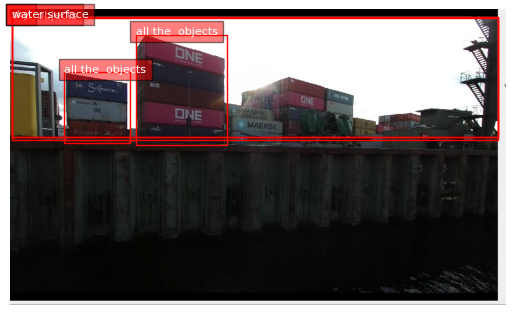

In [23]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [55]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image and creates a binary mask.

    Parameters:
    - image: PIL Image object.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.

    Returns:
    - Annotated image.
    - Binary mask as a PIL Image (white for non-segmented regions, black for segmented regions).
    """
    # Ensure the input image is in RGBA mode
    if image.mode != 'RGBA':
        image = image.convert('RGBA')
    draw = ImageDraw.Draw(image)

    # Create a binary mask with a white background
    mask = Image.new('L', image.size, color=255)  # 'L' mode for grayscale, white background (255)
    mask_draw = ImageDraw.Draw(mask)

    # Set up a colormap for segment visualization
    colormap = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)  # For visualizing segmentation
        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = _polygon.reshape(-1).tolist()

            # Draw the polygon on the original image
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the polygon on the binary mask (black for segmented regions)
            mask_draw.polygon(_polygon, fill=0)  # Black (0) for segmented regions

    # Display the binary mask
    display(mask)
    display(image)
    return image, mask


In [62]:
from PIL import Image, ImageChops

def combine_masks_and_apply(image, mask1, mask2):
    """
    Combines two binary masks and applies the resulting mask to the original image.

    Parameters:
    - image: PIL Image object (RGB).
    - mask1: First binary mask (PIL Image, mode 'L').
    - mask2: Second binary mask (PIL Image, mode 'L').

    Returns:
    - combined_mask: Binary mask showing the overlapping white regions.
    - masked_image: Original image with non-overlapping regions turned black.
    """
    # Ensure both masks are in grayscale mode ('L')
    if mask1.mode != 'L':
        mask1 = mask1.convert('L')
    if mask2.mode != 'L':
        mask2 = mask2.convert('L')

    # Combine masks using bitwise AND to find overlapping white regions
    combined_mask = ImageChops.multiply(mask1, mask2)

    # Apply the combined mask to the original image
    masked_image = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), combined_mask)

    # Display outputs
    display(combined_mask)  # Display the combined mask
    display(masked_image)  # Display the masked image

    return combined_mask, masked_image


In [56]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="detect all the  objects")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[103.2750015258789, 118.42549896240234, 106.02899932861328, 118.42549896240234, 111.53699493408203, 119.51950073242188, 112.45499420166016, 120.61349487304688, 117.96299743652344, 121.7074966430664, 124.38899993896484, 121.7074966430664, 125.30699920654297, 122.80149841308594, 130.81500244140625, 123.34849548339844, 137.24099731445312, 123.34849548339844, 138.15899658203125, 124.44249725341797, 142.74899291992188, 125.5364990234375, 149.1750030517578, 125.5364990234375, 150.09300231933594, 126.63050079345703, 154.68299865722656, 127.72449493408203, 161.10899353027344, 127.72449493408203, 162.02699279785156, 128.81849670410156, 167.53500366210938, 129.36549377441406, 173.96099853515625, 129.36549377441406, 180.38699340820312, 130.45950317382812, 181.30499267578125, 131.55349731445312, 186.81300354003906, 132.64749145507812, 192.3209991455078, 132.64749145507812, 193.23899841308594, 133.7415008544922, 197.82899475097656, 134.83549499

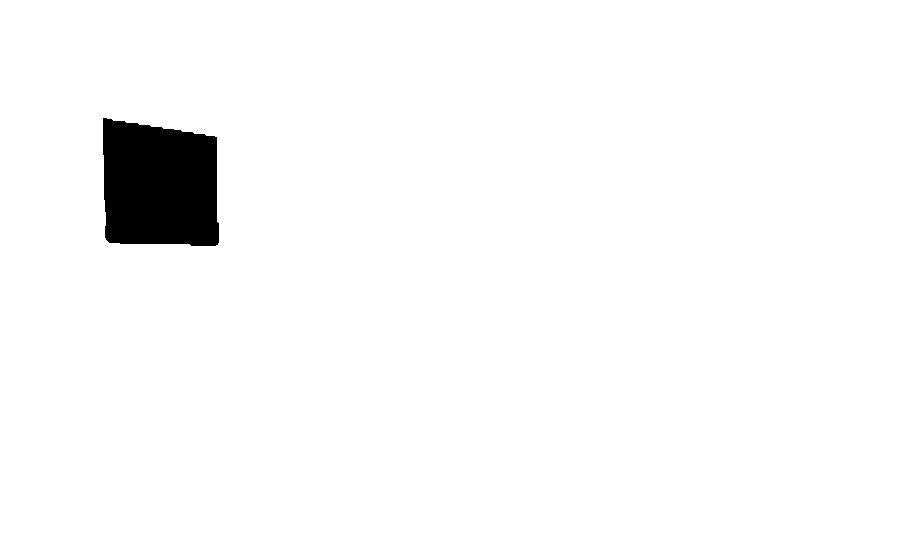

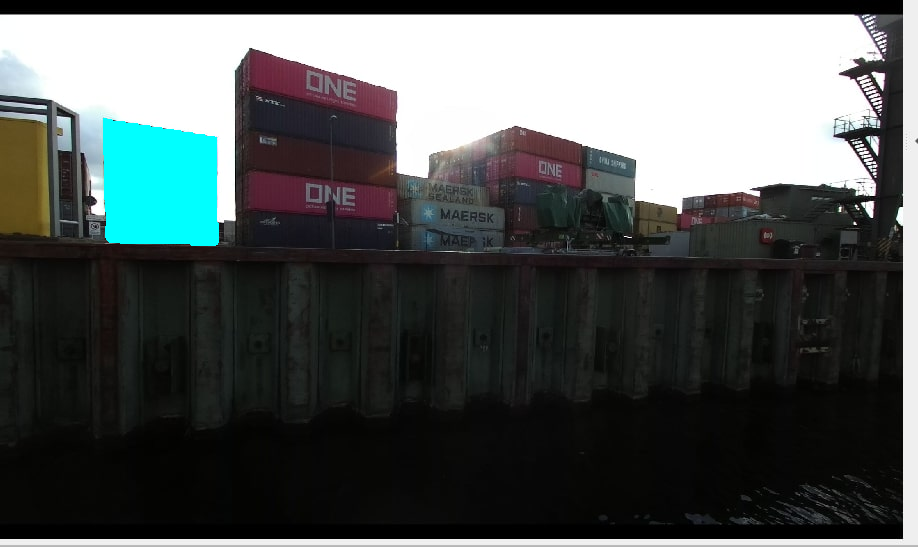

(<PIL.Image.Image image mode=RGBA size=918x547>,
 <PIL.Image.Image image mode=L size=918x547>)

In [57]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999].

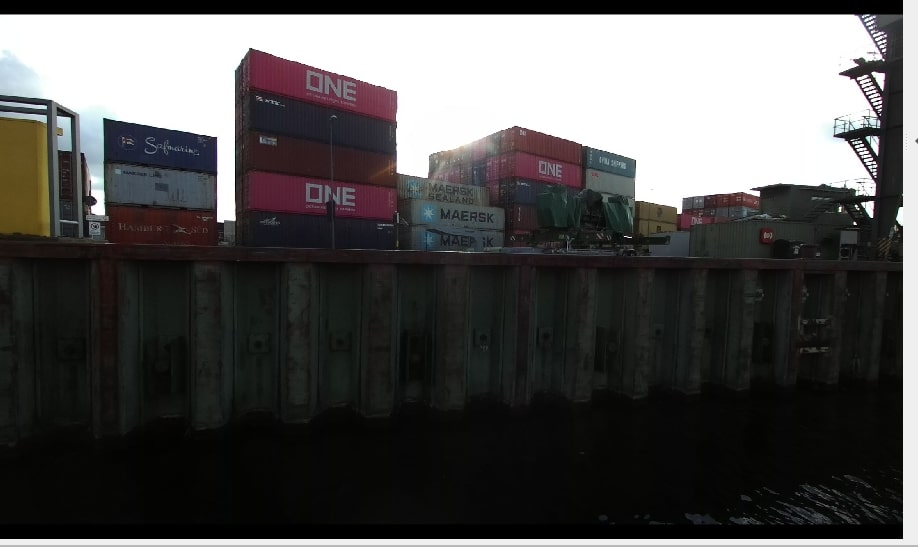

In [58]:
image = Image.open('/content/Screenshot from 2025-01-05 21-04-39.jpg')
image

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[0.45899999141693115, 15.589499473571777, 856.0349731445312, 15.589499473571777, 858.7890014648438, 18.87150001525879, 860.625, 21.60649871826172, 861.54296875, 24.888500213623047, 863.3789672851562, 26.529499053955078, 864.2969970703125, 29.811498641967773, 866.1329956054688, 31.452499389648438, 867.0509643554688, 34.734500885009766, 868.886962890625, 36.92250061035156, 869.8049926757812, 39.657501220703125, 872.5589599609375, 41.84550094604492, 873.4769897460938, 44.58049774169922, 875.31298828125, 46.768497467041016, 876.23095703125, 49.50349807739258, 876.23095703125, 52.785499572753906, 874.3949584960938, 54.42649841308594, 872.5589599609375, 55.52050018310547, 868.886962890625, 56.614498138427734, 866.1329956054688, 56.614498138427734, 863.3789672851562, 54.42649841308594, 861.54296875, 54.42649841308594, 858.7890014648438, 56.614498138427734, 856.0349731445312, 56.614498138427734, 854.198974609375, 57.708499908447266, 852.3629760742188

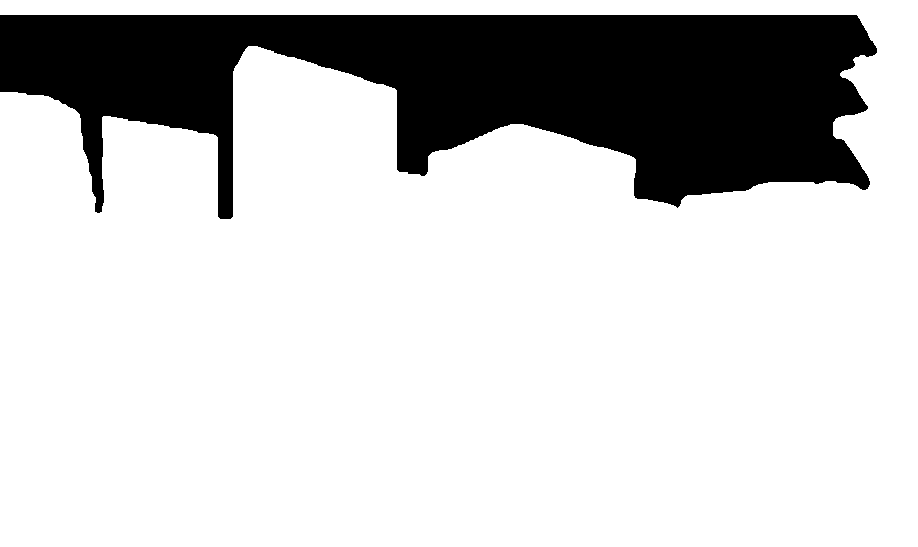

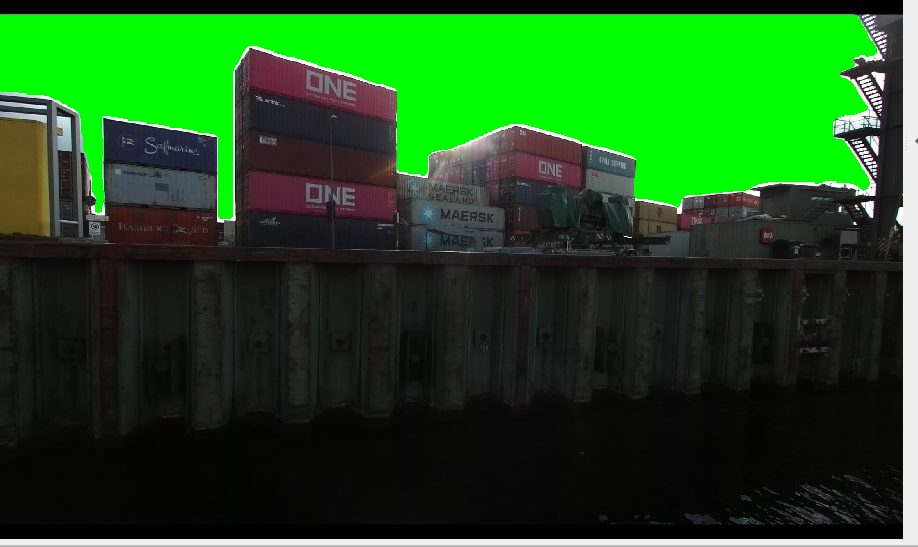

In [60]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="detect all sky")
print(results)
output_image = copy.deepcopy(image)
image_sky, mask_sky = draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[158.35499572753906, 418.1814880371094, 181.30499267578125, 418.1814880371094, 184.97698974609375, 419.2754821777344, 186.81300354003906, 420.3695068359375, 188.6490020751953, 422.010498046875, 188.6490020751953, 424.198486328125, 189.56700134277344, 425.8395080566406, 191.4029998779297, 428.0274963378906, 193.23899841308594, 429.1214904785156, 195.9929962158203, 430.2154846191406, 206.09100341796875, 430.2154846191406, 213.43499755859375, 429.1214904785156, 218.02499389648438, 428.0274963378906, 220.77899169921875, 426.9335021972656, 223.53298950195312, 425.8395080566406, 225.36900329589844, 425.29248046875, 227.2050018310547, 423.1044921875, 229.95899963378906, 422.010498046875, 231.7949981689453, 420.3695068359375, 233.63099670410156, 419.2754821777344, 235.4669952392578, 419.2754821777344, 238.2209930419922, 417.0874938964844, 240.05699157714844, 417.0874938964844, 241.8929901123047, 415.9934997558594, 243.72898864746094, 414.352478027343

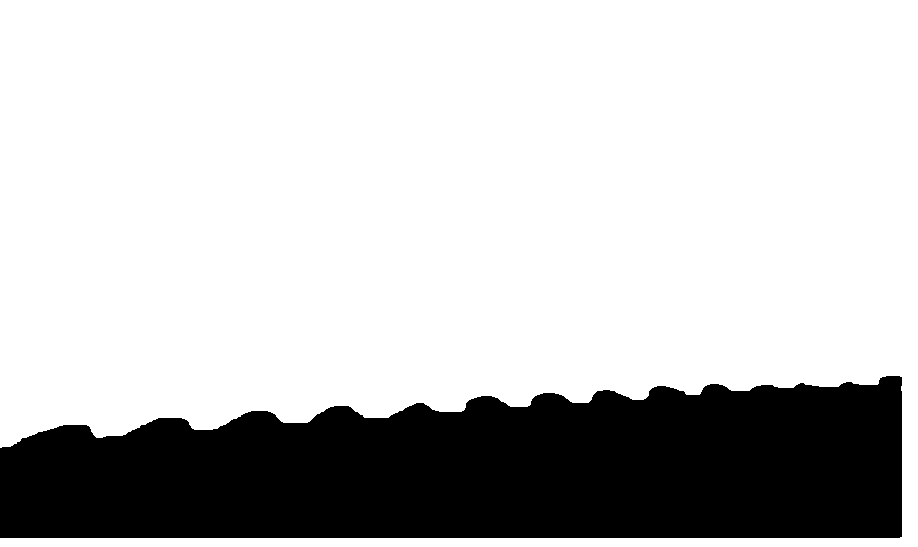

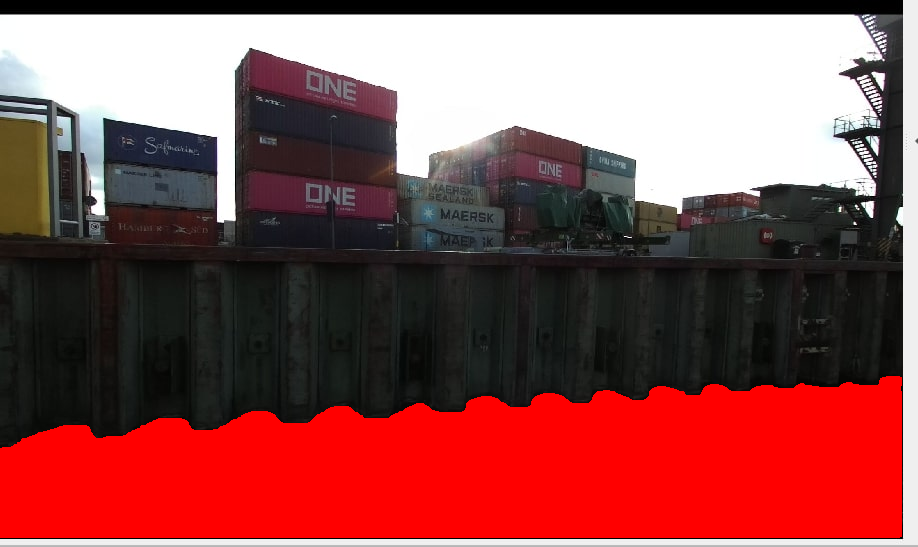

In [61]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results_sky = run_example(task_prompt, text_input="detect all water")
print(results_sky)
output_image = copy.deepcopy(image)
image_water, mask_water = draw_polygons(output_image, results_sky['<REGION_TO_SEGMENTATION>'], fill_mask=True)

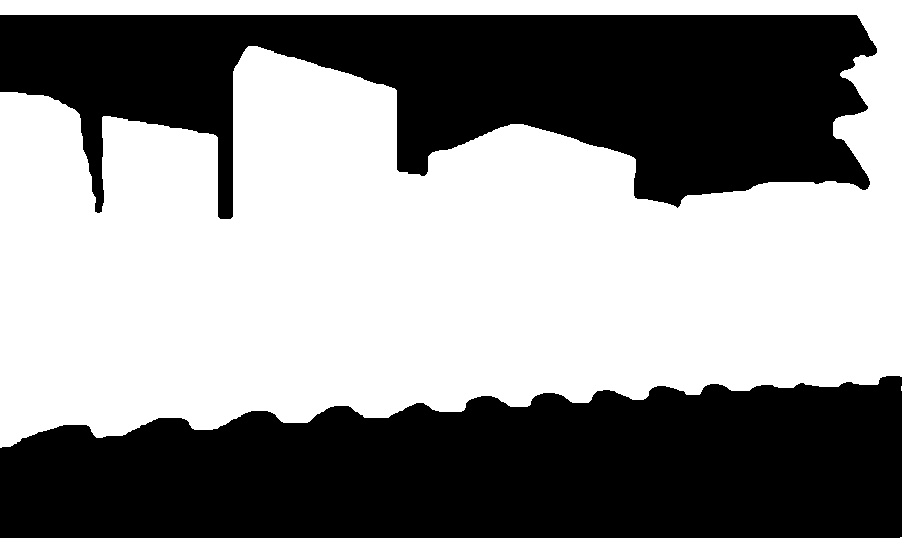

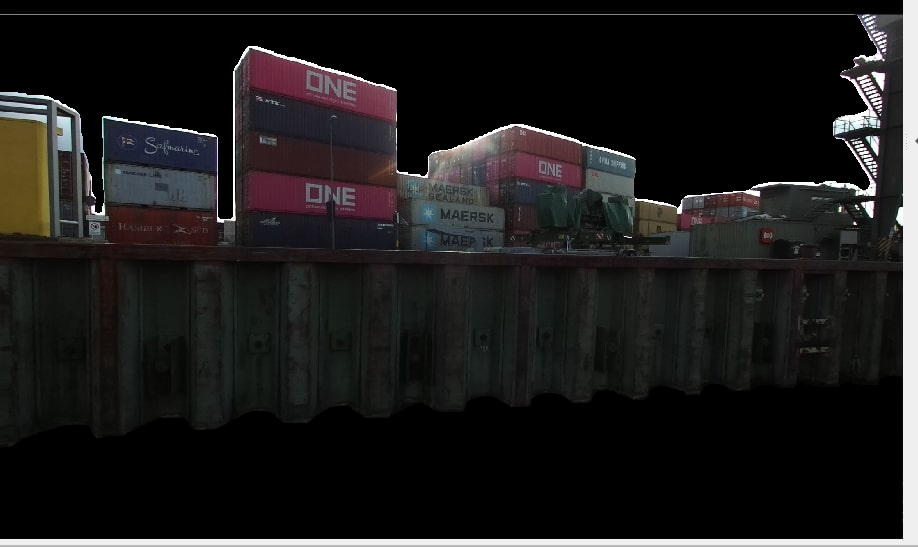

In [63]:
combined_mask, masked_image = combine_masks_and_apply(image, mask_sky, mask_water)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[158.35499572753906, 418.1814880371094, 181.30499267578125, 418.1814880371094, 184.97698974609375, 419.2754821777344, 186.81300354003906, 420.3695068359375, 188.6490020751953, 422.010498046875, 188.6490020751953, 424.198486328125, 189.56700134277344, 425.8395080566406, 191.4029998779297, 428.0274963378906, 193.23899841308594, 429.1214904785156, 195.9929962158203, 430.2154846191406, 206.09100341796875, 430.2154846191406, 213.43499755859375, 429.1214904785156, 218.02499389648438, 428.0274963378906, 220.77899169921875, 426.9335021972656, 223.53298950195312, 425.8395080566406, 225.36900329589844, 425.29248046875, 227.2050018310547, 423.1044921875, 229.95899963378906, 422.010498046875, 231.7949981689453, 420.3695068359375, 233.63099670410156, 419.2754821777344, 235.4669952392578, 419.2754821777344, 238.2209930419922, 417.0874938964844, 240.05699157714844, 417.0874938964844, 241.8929901123047, 415.9934997558594, 243.72898864746094, 414.352478027343

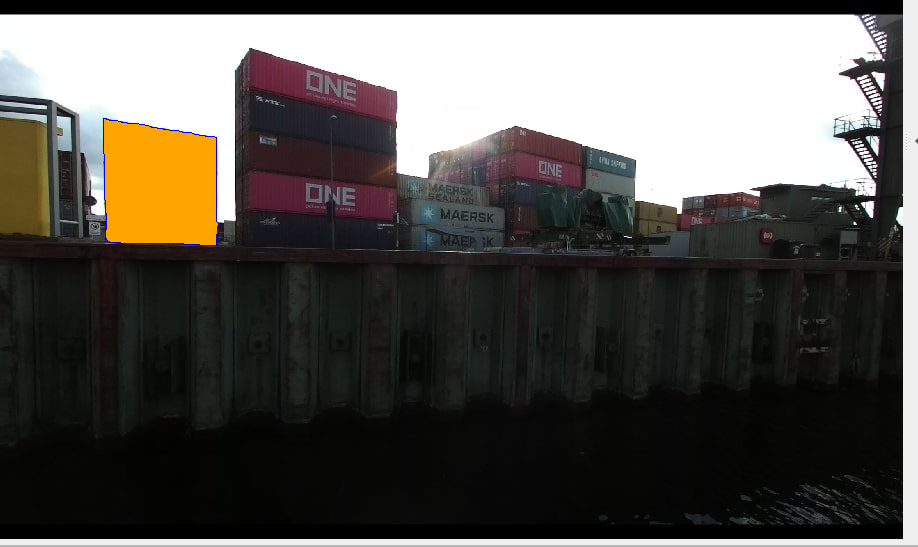

In [32]:
task_prompt = '<REGION_TO_SEGMENTATION>'
text_input = "segment all visible objects in the image"
result = run_example(task_prompt, text_input=text_input)
print(results_sky)
output_image = copy.deepcopy(image)
output_image = draw_polygons(output_image, result['<REGION_TO_SEGMENTATION>'], fill_mask=True)

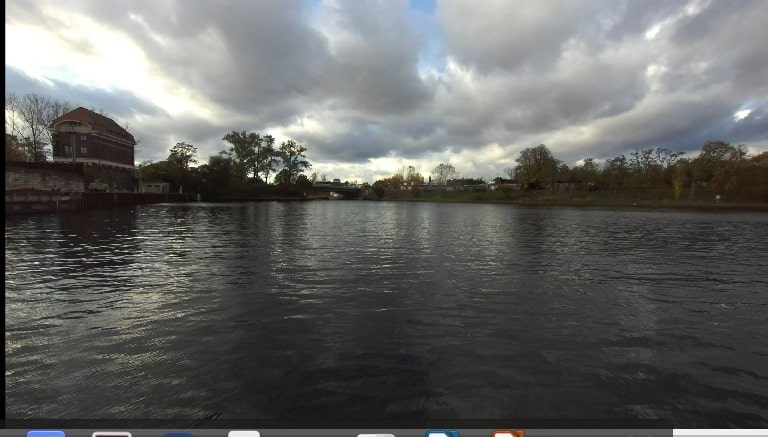

In [64]:
image = Image.open('/content/Screenshot from 2025-01-05 21-11-24.jpg')
image

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[0.45899999141693115, 15.589499473571777, 856.0349731445312, 15.589499473571777, 858.7890014648438, 18.87150001525879, 860.625, 21.60649871826172, 861.54296875, 24.888500213623047, 863.3789672851562, 26.529499053955078, 864.2969970703125, 29.811498641967773, 866.1329956054688, 31.452499389648438, 867.0509643554688, 34.734500885009766, 868.886962890625, 36.92250061035156, 869.8049926757812, 39.657501220703125, 872.5589599609375, 41.84550094604492, 873.4769897460938, 44.58049774169922, 875.31298828125, 46.768497467041016, 876.23095703125, 49.50349807739258, 876.23095703125, 52.785499572753906, 874.3949584960938, 54.42649841308594, 872.5589599609375, 55.52050018310547, 868.886962890625, 56.614498138427734, 866.1329956054688, 56.614498138427734, 863.3789672851562, 54.42649841308594, 861.54296875, 54.42649841308594, 858.7890014648438, 56.614498138427734, 856.0349731445312, 56.614498138427734, 854.198974609375, 57.708499908447266, 852.3629760742188

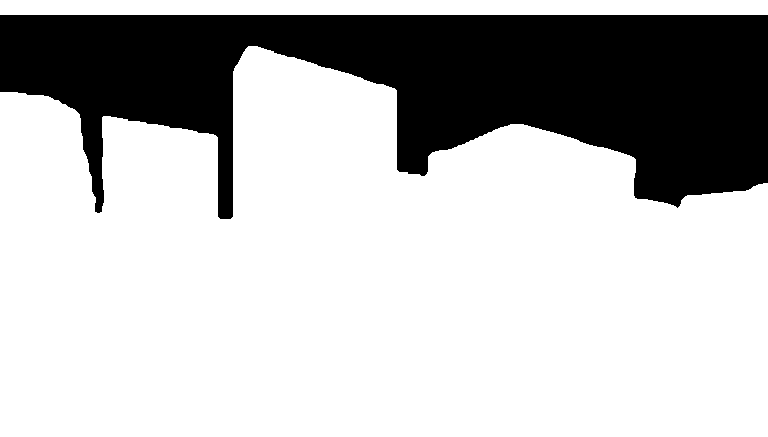

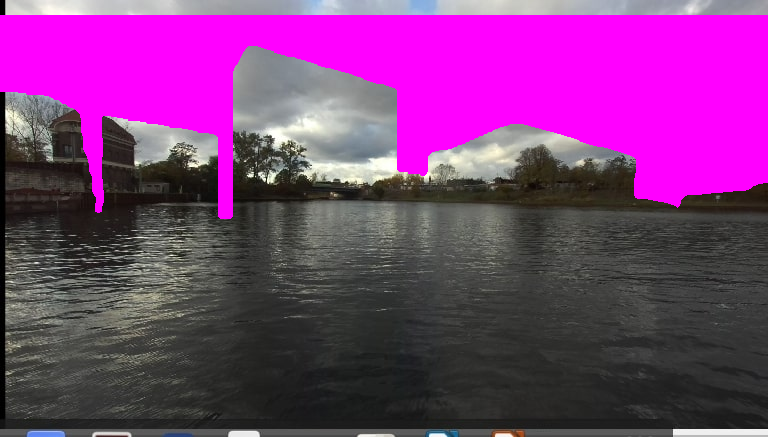

In [69]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results_sky = run_example(task_prompt, text_input="detect all sky")
print(results)
output_image = copy.deepcopy(image)
image_sky, mask_sky  = draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[38.01599884033203, 213.9114990234375, 55.68000030517578, 213.9114990234375, 56.448001861572266, 213.03750610351562, 65.66400146484375, 212.1634979248047, 77.9520034790039, 212.1634979248047, 78.72000122070312, 210.85250854492188, 88.7040023803711, 209.97850036621094, 101.76000213623047, 209.97850036621094, 102.52799987792969, 209.10450744628906, 113.27999877929688, 208.23049926757812, 124.03199768066406, 206.9195098876953, 136.32000732421875, 206.9195098876953, 137.08799743652344, 206.04550170898438, 144.0, 204.7344970703125, 156.28799438476562, 203.86050415039062, 192.38400268554688, 202.9864959716797, 194.68800354003906, 202.9864959716797, 195.4560089111328, 203.86050415039062, 204.6719970703125, 202.9864959716797, 207.74400329589844, 202.9864959716797, 216.9600067138672, 203.86050415039062, 217.72799682617188, 202.9864959716797, 246.1439971923828, 202.1125030517578, 279.1679992675781, 200.80149841308594, 282.239990234375, 200.801498413085

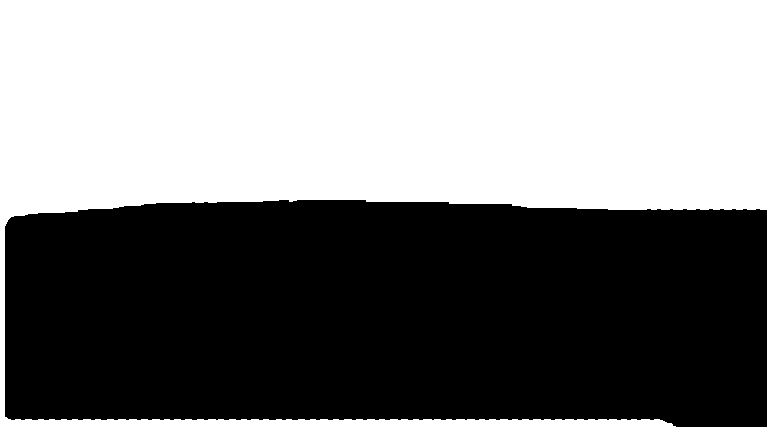

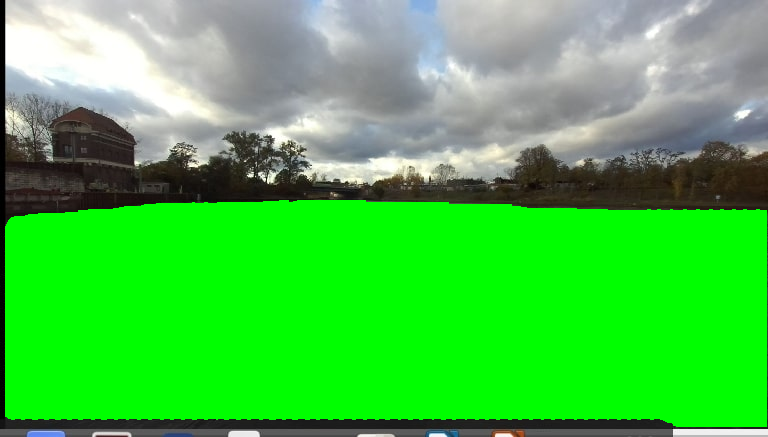

In [70]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results_sky = run_example(task_prompt, text_input="detect all water")
print(results_sky)
output_image = copy.deepcopy(image)
image_water, mask_water  = draw_polygons(output_image, results_sky['<REGION_TO_SEGMENTATION>'], fill_mask=True)

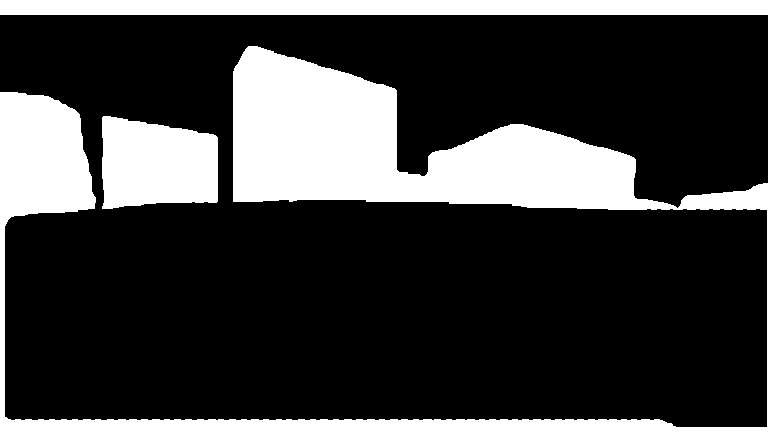

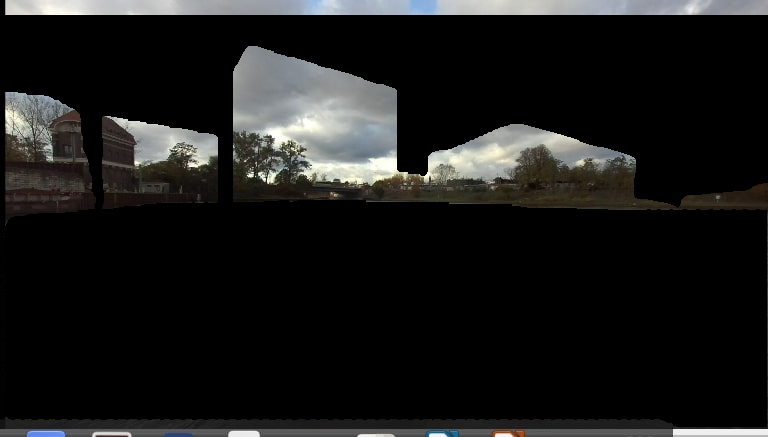

In [71]:
combined_mask, masked_image = combine_masks_and_apply(image, mask_sky, mask_water)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[77.9520034790039, 107.28350067138672, 84.09600067138672, 107.28350067138672, 87.16799926757812, 108.15750122070312, 90.23999786376953, 109.46849822998047, 93.31200408935547, 111.21649932861328, 94.8479995727539, 111.21649932861328, 97.91999816894531, 113.40150451660156, 100.2239990234375, 113.40150451660156, 103.2959976196289, 115.14949798583984, 104.83200073242188, 115.14949798583984, 107.90399932861328, 117.33450317382812, 110.20800018310547, 117.33450317382812, 111.74400329589844, 118.20850372314453, 114.81600189208984, 120.39350128173828, 120.19200134277344, 125.20050048828125, 120.95999908447266, 125.20050048828125, 124.03199768066406, 127.38550567626953, 130.17599487304688, 132.1925048828125, 134.78399658203125, 137.43650817871094, 134.78399658203125, 139.18450927734375, 136.32000732421875, 142.24349975585938, 136.32000732421875, 144.42849731445312, 134.01600646972656, 146.17649841308594, 134.01600646972656, 165.4044952392578, 134.7839

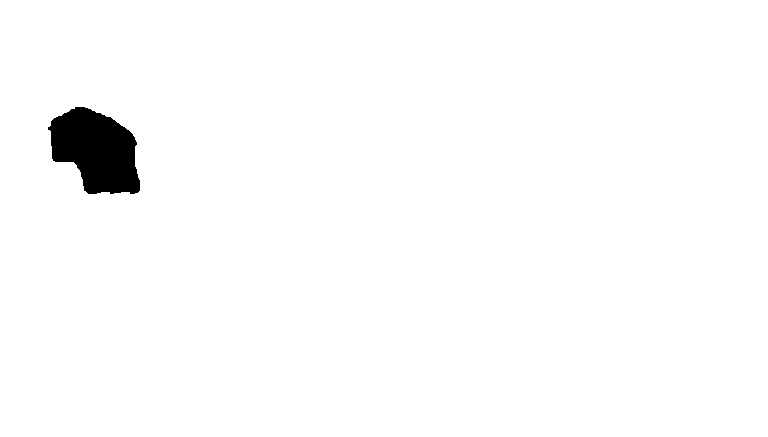

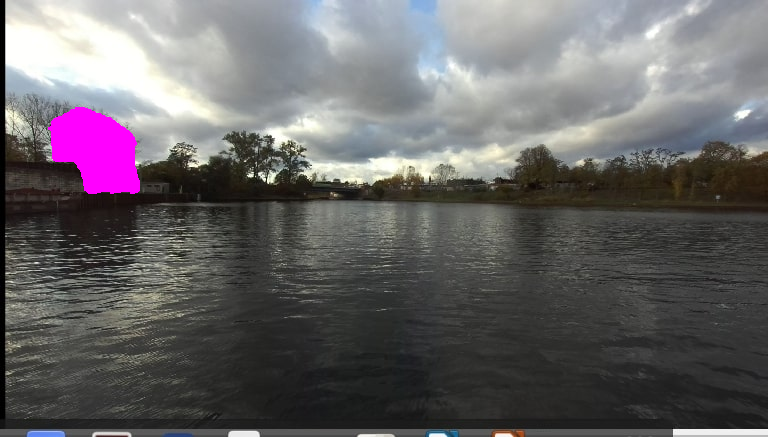

In [68]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results_sky = run_example(task_prompt, text_input="segment everything")
print(results_sky)
output_image = copy.deepcopy(image)
image_water = draw_polygons(output_image, results_sky['<REGION_TO_SEGMENTATION>'], fill_mask=True)

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [ ]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="detect all the  objects, not sky or water surface")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[5.760000228881836, 196.86849975585938, 765.31201171875, 428.04150390625]], 'bboxes_labels': ['detect all the  objects, not sky or water surface'], 'polygons': [], 'polygons_labels': []}}


In [ ]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [ ]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

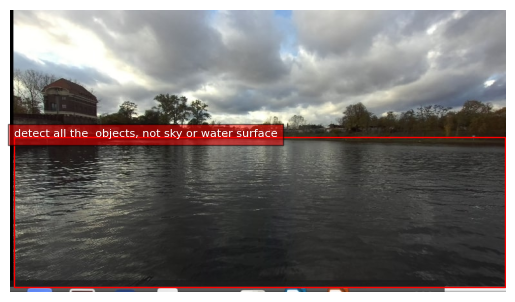

In [ ]:
plot_bbox(image, bbox_results)

### region to texts

In [ ]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'boat<loc_52><loc_332><loc_932><loc_774>'}


In [ ]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'freight container terminal<loc_52><loc_332><loc_932><loc_774>'}


## Cascaded tasks

### Caption + Phrase Grounding

results format:

{
 '\<CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('/content/Screenshot from 2025-01-05 21-04-39.jpg')

In [ ]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[231.7949981689453,
    46.221500396728516,
    403.46099853515625,
    251.34649658203125],
   [424.5749816894531,
    123.89550018310547,
    641.2229614257812,
    249.1584930419922],
   [99.60299682617188,
    115.69049835205078,
    222.614990234375,
    249.1584930419922],
   [3.2129998207092285,
    45.67449951171875,
    894.5910034179688,
    257.3634948730469],
   [2.2950000762939453,
    237.12449645996094,
    903.77099609375,
    448.8135070800781]],
  'labels': ['A bunch of shipping containers',
   'A bunch of shipping containers',
   'A bunch of shipping containers',
   'containers',
   'a dock']},
 '<CAPTION>': 'A bunch of shipping containers sitting on top of a dock.'}

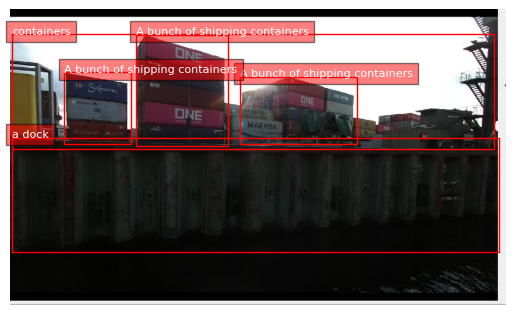

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding

results format:

{
 '\<DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[3.2129998207092285,
    236.03050231933594,
    902.8529663085938,
    446.0784912109375],
   [231.7949981689453, 46.221500396728516, 401.625, 250.25250244140625],
   [424.5749816894531,
    123.89550018310547,
    639.386962890625,
    248.0644989013672],
   [99.60299682617188,
    115.69049835205078,
    220.77899169921875,
    247.5175018310547],
   [231.7949981689453,
    46.221500396728516,
    400.7070007324219,
    250.25250244140625],
   [424.5749816894531,
    124.44249725341797,
    639.386962890625,
    248.0644989013672],
   [827.5769653320312, 12.307499885559082, 903.77099609375, 259.5514831542969],
   [1.3769999742507935,
    92.71649932861328,
    93.177001953125,
    242.04750061035156],
   [2.2950000762939453,
    13.40149974822998,
    901.9349975585938,
    223.44949340820312]],
  'labels': ['a dock',
   'a number',
   'a number',
   'a number',
   'containers',
   'containers',
   'a few metal objects',
   'a few metal 

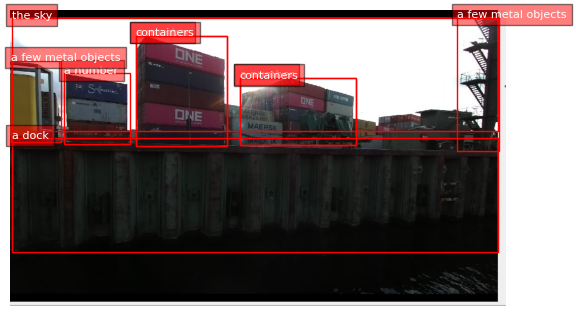

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding

results format:

{
 '\<MORE_DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[232.71299743652344,
    46.221500396728516,
    400.7070007324219,
    248.6114959716797],
   [425.49298095703125,
    123.34849548339844,
    638.468994140625,
    245.87649536132812],
   [100.52099609375,
    115.14350128173828,
    219.86099243164062,
    245.87649536132812],
   [828.4949951171875, 12.307499885559082, 903.77099609375, 257.9104919433594],
   [3.2129998207092285,
    13.94849967956543,
    899.1809692382812,
    214.15049743652344]],
  'labels': ['The containers',
   'The containers',
   'The containers',
   'a crane',
   'The sky']},
 '<MORE_DETAILED_CAPTION>': 'The image shows a large number of shipping containers stacked on top of each other. The containers are of different colors and sizes, with some being red, blue, green, and yellow. They are stacked on a concrete wall, and there is a crane on the right side of the image. The sky is overcast and the ground is wet, suggesting that it has recently rained. The image ap

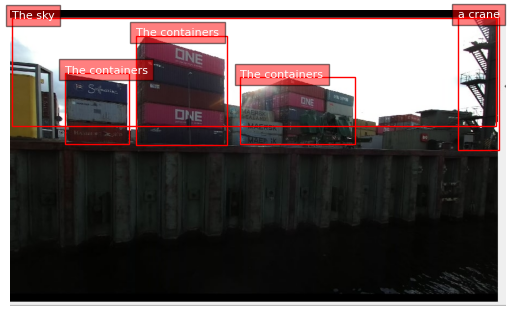

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])